In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

# project_dir = '/content/gdrive/MyDrive/unet_model/'; os.makedirs(project_dir, exist_ok=True)
# %cd $project_dir



Mounted at /content/gdrive
/content/gdrive/MyDrive/unet_model


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from pathlib import Path

!pip install -qU PyMuPDF

%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 76.9 MB/s eta 0:00:00


#### LARGE image loading --
     Load large images and resize them to 512x512 for the training
     

In [38]:
# ~36s LOADING w pickle cache RUN
# RUN ----------------------------> XXXX ??

import numpy as np
import os
import cv2
from tqdm import tqdm
import pickle
from pathlib import Path


IMG_HEIGHT = 512
IMG_WIDTH = 512


def process_image_batch(paths, batch_size=32):
    """
    Process images in batches by, resizing, grayscaling, normalizing, and
    returning them as numpy arrays for efficient handling of large datasets.

    Args: image paths (list of str), batch_size (int)
    Yields: numpy.ndarray: Batch of preprocessed images.
    """

    for i in tqdm(range(0, len(paths), batch_size), desc="Processing images"):
        batch_paths = paths[i:i + batch_size]
        batch_images = []
        for path in batch_paths:
            if os.path.exists(path):
                img = cv2.imread(path)
                img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_AREA)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = img.astype('float32') / 255.0
                img = np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1))
                batch_images.append(img)
            else:
                print(f"File not found: {path}") # Log missing files
        yield np.array(batch_images) # Yield preprocessed batch as numpy array

def load_or_process_images(image_paths, cache_file):
    """
    Load preprocessed images from a cache file if it exists; otherwise,
    process images from the given paths, save them to the cache, and return them as numpy arrays.

    Args:    image_paths (list of str), cache_file (str)
    Returns: numpy.ndarray preprocessed images.
    """

    if os.path.exists(cache_file): # Check if cache file exists
        print(f"Loading cached data from {cache_file}")
        with open(cache_file, 'rb') as f: # Load and return cached images
            return pickle.load(f)

    images = []
    for batch in process_image_batch(image_paths): # Process images in batches
        images.extend(batch)

    images = np.array(images)
    print(f"Saving processed data to {cache_file}")
    with open(cache_file, 'wb') as f: # Save processed images to cache file
        pickle.dump(images, f)

    return images



In [41]:

#  LOADING CACHED LARGE IMGS

# For loading, load_or_process_images checks if there is a cached version, if not it processes and caches them

data_dir = '/content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/shabby01'
large_cache_dir = Path(f'{data_dir}/shabby/shabby_images_cache'); large_cache_dir.mkdir(exist_ok=True)

!ls '{data_dir}/shabby/validate'

# --------------- LARGE TRAIN IMAGES -----------------------------------------------------
train_shabby_img = [os.path.join(f'{data_dir}/shabby/train/all_train_shabby', img) for img in sorted(os.listdir(f'{data_dir}/shabby/train/all_train_shabby'))]
train_cleaned_img = [os.path.join(f'{data_dir}/shabby/train/all_train_cleaned', img) for img in sorted(os.listdir(f'{data_dir}/shabby/train/all_train_cleaned'))]


# only loading 10 for testing, comment out if not needed
train_shabby_img = train_shabby_img[:10]
train_cleaned_img = train_cleaned_img[:10]
print(len(train_shabby_img), len(train_cleaned_img))

X_train = load_or_process_images(train_shabby_img, large_cache_dir / "X_train_11.pkl")
Y_train = load_or_process_images(train_cleaned_img, large_cache_dir / "Y_train_11.pkl")

# raise SystemExit
# -------------------LARGE VALIDATE IMAGES ------------------------------------------------

val_shabby_img = [os.path.join(f'{data_dir}/shabby/validate/validate_shabby/', img) for img in sorted(os.listdir(f'{data_dir}/shabby/validate/validate_shabby/'))]
val_cleaned_img = [os.path.join(f'{data_dir}/shabby/validate/validate_cleaned/', img) for img in sorted(os.listdir(f'{data_dir}/shabby/validate/validate_cleaned/'))]
# print(len(test_shabby_img), len(test_cleaned_img))


# only loading 10 for testing, comment out if not needed
val_shabby_img = val_shabby_img[:10]
val_cleaned_img = val_cleaned_img[:10]
print(len(val_shabby_img), len(val_cleaned_img))
print(len(val_cleaned_img))

X_val = load_or_process_images(val_shabby_img, large_cache_dir / "X_val_10.pkl")
Y_val = load_or_process_images(val_cleaned_img, large_cache_dir / "Y_val_12.pkl")


# ----------------- LARGE TEST IMAGES -----------------------------------------------------
test_shabby_img = [os.path.join(f'{data_dir}/shabby/test/test_shabby/', img) for img in sorted(os.listdir(f'{data_dir}/shabby/test/test_shabby/'))]
test_cleaned_img = [os.path.join(f'{data_dir}/shabby/test/test_cleaned/', img) for img in sorted(os.listdir(f'{data_dir}/shabby/test/test_cleaned/'))]
print(len(test_shabby_img), len(test_cleaned_img))


# only loading 10 for testing, comment out if not needed
test_shabby_img = test_shabby_img[:10]
test_cleaned_img = test_cleaned_img[:10]
print(len(test_shabby_img), len(test_cleaned_img))

X_test = load_or_process_images(test_shabby_img, large_cache_dir / "X_test_10.pkl")
Y_test = load_or_process_images(test_cleaned_img, large_cache_dir / "Y_test_10.pkl")


# # Print shapes of the images in the data sets
print(f"Shape of X_train: {X_train.shape}") # (1135, 512, 512, 1)
print(f"Shape of Y_train: {Y_train.shape}\n") # (1135, 512, 512, 1)

print(f"Shape of X_test: {X_test.shape}") # (142, 512, 512, 1)
print(f"Shape of Y_test: {Y_test.shape}\n") # (142, 512, 512, 1)

print(f"Shape of X_val: {X_val.shape}") # (142, 512, 512, 1)
print(f"Shape of Y_val: {Y_val.shape}") # (142, 512, 512, 1)

validate_cleaned  validate_shabby
10 10
Loading cached data from /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/shabby01/shabby/shabby_images_cache/X_train_11.pkl
Loading cached data from /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/shabby01/shabby/shabby_images_cache/Y_train_11.pkl
10 10
10
Loading cached data from /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/shabby01/shabby/shabby_images_cache/X_val_10.pkl
Loading cached data from /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/shabby01/shabby/shabby_images_cache/Y_val_12.pkl
142 142
10 10
Loading cached data from /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/shabby01/shabby/shabby_images_cache/X_test_10.pkl
Loading cached data from /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/shabby01/shabby/shabby_images_cache/Y_t

However, we soon realize the images are actually too large for training so we get 512x512 patches from each image
The same patch sizes are used for prediction so they must correspond between shabby and clean images for all of train, validation and test_cleaned_img
The exact same processing procedure is used on all images

### Image Processing by Patching and Unpatching:

- Functions to process, patch and unpatch, and to visualize matching pairs
- Pipeline to patch large images
- Pipeline to loach patched images from cache

In [7]:
import os
import cv2
import random
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt



In [8]:
# Functions to process, patch and unpatch the large images
# Also function to visualize maching pairs

def split_image(image, window_height=512, window_width=512):
    """
    Split an image into overlapping windows of specified dimensions
    with padding for incomplete regions.

    Args:      image (numpy.ndarray), window_height (int), window_width (int)
    Returns:   list of numpy.ndarray image windows, list of tuple positions
    """
    h, w = image.shape[:2]
    channels = 1 if len(image.shape) == 2 else image.shape[2] # Set channles for grayscale or color
    windows = []
    positions = []  # Track positions for reconstruction

    for y in range(0, h, window_height):
        for x in range(0, w, window_width):
            window = image[y:y+window_height, x:x+window_width] # Extract window
            if window.shape[0] != window_height or window.shape[1] != window_width: # Pad if window dimensions are smaller than target size
                pad_h = window_height - window.shape[0]
                pad_w = window_width - window.shape[1]
                window = np.pad(window,
                              ((0, pad_h), (0, pad_w)) if channels == 1 else ((0, pad_h), (0, pad_w), (0, 0)),
                              'reflect')  # Use reflect padding for better edge handling
            windows.append(window)
            positions.append((y, x)) # Track position of the window

    return windows, positions


def stitch_image(windows, original_shape, window_height, window_width):
    """
    Reconstruct image by stitching windows into their original dimensions.

    Args:      windows (list of numpy.ndarray), original_shape (tuple),
               window_height (int), window_width (int)
    Returns:   numpy.ndarray reconstructed image
    """
    h, w = original_shape[:2]
    channels = 1 if len(windows[0].shape) == 2 else windows[0].shape[2]
    stitched_image = np.zeros((h, w) if channels == 1 else (h, w, channels), dtype=windows[0].dtype)

    i = 0
    for y in range(0, h, window_height):
        for x in range(0, w, window_width):
            actual_h = min(window_height, h - y) # Determine actual height to copy
            actual_w = min(window_width, w - x)  # Determine actual width to copy
            stitched_image[y:y+actual_h, x:x+actual_w] = windows[i][:actual_h, :actual_w] # Copy window
            i += 1 # next window

    return stitched_image


def process_matching_images(shabby_dir, clean_dir, output_dir='../shabby01/image_patches', window_size=512):
    """
    Generate and save matching image patches from shabby and clean image directories.

    Args:  shabby_dir (str): shabby|noisy images dir.
           clean_dir (str):  clean|target images dir.
           output_dir (str): Dir to save image patches. Default is '../shabby01/image_patches'.
           window_size (int): Size of the patches to extract. Default is 512.
    Returns: None
    """

    # Create output directories
    Path(f"{output_dir}/shabby_patches").mkdir(parents=True, exist_ok=True)
    Path(f"{output_dir}/clean_patches").mkdir(parents=True, exist_ok=True)

    # Get matching filenames between shabby and clean directories
    shabby_files = set(os.listdir(shabby_dir)) #[:2])
    clean_files = set(os.listdir(clean_dir)) #[:2])
    matching_files = list(shabby_files.intersection(clean_files))

    for filename in matching_files:
        # Load image pairs
        shabby_img = cv2.imread(os.path.join(shabby_dir, filename), 0)
        clean_img = cv2.imread(os.path.join(clean_dir, filename), 0)

        # Get patches
        shabby_patches, _ = split_image(shabby_img, window_size, window_size)
        clean_patches, _ = split_image(clean_img, window_size, window_size)

        # Save corresponding patches
        base_name = filename.rsplit('.', 1)[0]
        for idx, (shabby_patch, clean_patch) in enumerate(zip(shabby_patches, clean_patches)):
            patch_name = f"{base_name}_patch{idx}.png"
            cv2.imwrite(f"{output_dir}/shabby_patches/{patch_name}", shabby_patch)
            cv2.imwrite(f"{output_dir}/clean_patches/{patch_name}", clean_patch)

        print(f"Processed {filename}: {len(shabby_patches)} patches")


# Usage
# shabby_dir_VAL = '../shabby01/shabby/validate/validate_shabby' #'../patch_train_shabby'
# clean_dir_VAL = '../shabby01/shabby/validate/validate_cleaned' #'../patch_train_cleaned'
# output_dir_VAL = '../shabby01/image_patches/validate'
# process_matching_images(shabby_dir_VAL, clean_dir_VAL, output_dir=output_dir_VAL)



# VISUALIZING MATCHING PAIRS --- clean and shabby patch pairs

def show_matching_patches(shabby_dir='../patches/shabby_patches',
                         clean_dir='../patches/clean_patches',
                         num_pairs=3):
    """
    Display a sample of matching shabby and clean patches side by side.

    Args:  shabby_dir (str), clean_dir (str),
           num_pairs (int): Number of matching patch pairs to display. Default is 3.
    Returns: None
    """

    # Get all matching files
    files = os.listdir(shabby_dir)
    selected = random.sample(files, num_pairs)

    # Create a plot for shabby and clean patches
    fig, axes = plt.subplots(num_pairs, 2, figsize=(10, 5*num_pairs))
    fig.suptitle('Shabby vs Clean Patches', fontsize=16)

    for idx, filename in enumerate(selected):
        # Load shabby and clean patches
        shabby = cv2.imread(os.path.join(shabby_dir, filename), 0)
        clean = cv2.imread(os.path.join(clean_dir, filename), 0)

        # Display shabby patch
        axes[idx, 0].imshow(shabby, cmap='gray')
        axes[idx, 0].set_title(f'Shabby {filename}')
        axes[idx, 0].axis('off')

        # Display clean patch
        axes[idx, 1].imshow(clean, cmap='gray')
        axes[idx, 1].set_title(f'Clean {filename}')
        axes[idx, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Usage
show_matching_patches()


In [ ]:
# A.PATCH matching pairs and store in ../shabby01/image_patches
          # 1. get large images
          # 2. process them into patches with process_matching_images
          # 3. save them to {data_dir}/image_patches/train

data_dir = '/content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/shabby01'
image_patches = Path(f'{data_dir}/image_patches')
cache_dir = Path(f'{data_dir}/cache_patches/'); cache_dir.mkdir(exist_ok=True)


# TRAIN ----------------------------------------------------

# Usage
shabby_dir_train = train_shabby_img #'../shabby01/shabby/train/all_train_shabby' #'../patch_train_shabby'
clean_dir_train = train_shabby_img  #'../shabby01/shabby/train/all_train_cleaned' #'../patch_train_cleaned'
output_dir_train = f'{data_dir}/image_patches/train'; os.makedirs(output_dir_train, exist_ok=True)

process_matching_images(shabby_dir_train, clean_dir_train, output_dir=output_dir_train)

!ls '{data_dir}/train/all_train_shabby' | wc -l
!ls .'{data_dir}/train/all_train_cleaned' | wc -l

!ls '{output_dir_train}/shabby_patches' | wc -l
!ls '{output_dir_train}/clean_patches' | wc -l




# VALIDATE -------------------------------------------------------

# Usage
shabby_dir_val = val_shabby_img #'../shabby01/shabby/validate/validate_shabby' #'../patch_train_shabby'
clean_dir_val = val_cleaned_img #'../shabby01/shabby/validate/validate_cleaned' #'../patch_train_cleaned'
output_dir_val = f'{data_dir}/image_patches/validate'; os.makedirs(output_dir_train, exist_ok=True)#'../shabby01/image_patches/validate'

process_matching_images(shabby_dir_val, clean_dir_val, output_dir=output_dir_val)


!ls '{data_dir}/validate/validate_shabby' | wc -l
!ls .'{data_dir}/validate/validate_cleaned' | wc -l

!ls '{output_dir_val}/shabby_patches' | wc -l
!ls '{output_dir_val}/clean_patches' | wc -l




# TEST -------------------------------------------------------------
# Usage
shabby_dir_test = test_shabby_img
clean_dir_test = test_cleaned_img
output_dir_test = f'{data_dir}/image_patches/test'; os.makedirs(output_dir_train, exist_ok=True) #'../shabby01/image_patches/test'

process_matching_images(shabby_dir_test, clean_dir_test, output_dir=output_dir_test)


!ls '{data_dir}/test/test_shabby' | wc -l
!ls .'{data_dir}/test/test_cleaned' | wc -l

!ls '{output_dir_test}/shabby_patches' | wc -l
!ls '{output_dir_test}/clean_patches' | wc -l




In [13]:
# B.  LOADING CACHED PATCHED IMGS
# ~ 3-5min for all patches (19474 total )

# For loading, load_or_process_images checks if there is a cached version, if not it processes and caches them

                  # 1. get patched images fom {data_dir}/image_patches/train
                  # 2. load them from cache with load_or_process_images fn
                  #     - if cache is empty then load them from drive into cache then load from cache

data_dir = '/content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/shabby01'
image_patches = Path(f'{data_dir}/image_patches')
cache_dir = Path(f'{data_dir}/cache_patches/'); cache_dir.mkdir(exist_ok=True)


# -------------------------TRAINING PATCHES------------------------------------------------

train_shabby_patch_imgs = f'{image_patches}/train/shabby_patches' #'../patches/shabby_patches'
train_cleaned_patch_imgs = f'{image_patches}/train/clean_patches' #'../patches/clean_patches

train_shabby_patches = [os.path.join(train_shabby_patch_imgs, f) for f in os.listdir(train_shabby_patch_imgs)[:10]]
train_cleaned_patches = [os.path.join(train_cleaned_patch_imgs, f) for f in os.listdir(train_cleaned_patch_imgs)[:10]]


X_train_p = load_or_process_images(train_shabby_patches, cache_dir / "X_train_p_10.pkl")
Y_train_p = load_or_process_images(train_cleaned_patches, cache_dir / "Y_train_p_10.pkl")


print(f"Shape of X_train_p: {X_train_p.shape}") # (9453, 512, 512, 1)
print(f"Shape of Y_train_p: {Y_train_p.shape}\n") # (9453, 512, 512, 1)

# raise SystemExit
# -----------VALIDATION PATCHES--------------------------------

val_shabby_patch_imgs = f'{image_patches}/validate/shabby_patches' #'../patches/shabby_patches'
val_cleaned_patch_imgs = f'{image_patches}/validate/clean_patches' #'../patches/clean_patches'

val_shabby_patches = [os.path.join(val_shabby_patch_imgs, f) for f in os.listdir(val_shabby_patch_imgs)[:10]]
val_cleaned_patches = [os.path.join(val_cleaned_patch_imgs, f) for f in os.listdir(val_cleaned_patch_imgs)[:10]]

X_val_p = load_or_process_images(val_shabby_patches, cache_dir / "X_val_p_10.pkl")
Y_val_p = load_or_process_images(val_cleaned_patches, cache_dir / "Y_val_p_10.pkl")


print(f"Shape of X_val_p: {X_val_p.shape}") # (1636, 512, 512, 1)
print(f"Shape of Y_val_p: {Y_val_p.shape}\n") # (1636, 512, 512, 1)

# raise SystemExit

# --------------------TESTING PATCHES--------------------------------------------

test_shabby_patch_imgs = f'{image_patches}/test/shabby_patches' #'../patches/shabby_patches'
test_cleaned_patch_imgs = f'{image_patches}/test/clean_patches' #'../patches/clean_patches'


test_shabby_patches = [os.path.join(test_shabby_patch_imgs, f) for f in os.listdir(test_shabby_patch_imgs)[:10]]
test_cleaned_patches = [os.path.join(test_cleaned_patch_imgs, f) for f in os.listdir(test_cleaned_patch_imgs)[:10]]


X_test_p = load_or_process_images(test_shabby_patches, cache_dir / "X_test_p_10.pkl")
Y_test_p = load_or_process_images(test_cleaned_patches, cache_dir / "Y_test_p_10.pkl")


print(f"Shape of X_test_p: {X_test_p.shape}") # (1631, 512, 512, 1)
print(f"Shape of Y_test_p: {Y_test_p.shape}\n") # (1631, 512, 512, 1)



Loading cached data from /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/shabby01/cache_patches/X_train_p_10.pkl
Loading cached data from /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/shabby01/cache_patches/Y_train_p_10.pkl
Shape of X_train_p: (10, 512, 512, 1)
Shape of Y_train_p: (10, 512, 512, 1)



Processing images: 100%|██████████| 1/1 [00:07<00:00,  7.03s/it]


Saving processed data to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/shabby01/cache_patches/X_val_p_10.pkl


Processing images: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


Saving processed data to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/shabby01/cache_patches/Y_val_p_10.pkl
Shape of X_val_p: (10, 512, 512, 1)
Shape of Y_val_p: (10, 512, 512, 1)



Processing images: 100%|██████████| 1/1 [00:08<00:00,  8.13s/it]


Saving processed data to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/shabby01/cache_patches/X_test_p_10.pkl


Processing images: 100%|██████████| 1/1 [00:04<00:00,  4.17s/it]

Saving processed data to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/shabby01/cache_patches/Y_test_p_10.pkl
Shape of X_test_p: (10, 512, 512, 1)
Shape of Y_test_p: (10, 512, 512, 1)



In [14]:
# We get 19474 total patch images
total_patch_count = len(train_shabby_patches) + len(train_cleaned_patches) + len(test_shabby_patches) + len(test_cleaned_patches) + len(val_shabby_patches) + len(val_cleaned_patches)
print(f"Total patches: {total_patch_count}") # 25440 total



Total patches: 60


### Attempt 1: AutoEncoder baseline

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the SSIM loss function
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

# Input layer
input_layer = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))

# Encoding layers
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.5)(x)

# Decoding layers
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = UpSampling2D((2, 2))(x)

# Output layer
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Create and compile the model
model = Model(inputs=[input_layer], outputs=[output_layer])
model.compile(optimizer='adam', loss=ssim_loss, metrics=['mae'])
model.summary()


### Attempt 2: U-NET
- Loss functions
- Model architecture
- Training

- See example Architecture Diagram here: [LINK](https://code.likeagirl.io/u-net-vs-residual-u-net-vs-attention-u-net-vs-attention-residual-u-net-899b57c5698)


In [ ]:
# UNET -- Model Architecture

In [44]:
# Loss functions

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K

def ssim_loss(y_true, y_pred):
    """Calculate SSIM (structural similarity) loss.
      Args: y_true (tensor), y_pred (tensor)
      Returns: float SSIM loss value (1 - SSIM mean)
    """
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def combined_loss(y_true, y_pred):
    """Combined loss including SSIM and MSE for balanced optimization.
      Args: y_true (tensor), y_pred (tensor)
      Returns: float weighted loss value
    """
    ssim = ssim_loss(y_true, y_pred)
    mse = tf.keras.losses.mse(y_true, y_pred)
    return 0.7 * ssim + 0.3 * mse

def edge_preservation_loss(y_true, y_pred):
    """
    Compute edge preservation loss using Sobel edge detection.
    Args: y_true (tensor), y_pred (tensor)
    Returns: float edge preservation loss value
    """
    edge_true = tf.image.sobel_edges(y_true)
    edge_pred = tf.image.sobel_edges(y_pred)
    return tf.reduce_mean(tf.abs(edge_true - edge_pred))

def document_focused_loss(y_true, y_pred):
    """
    Combine SSIM, edge preservation, and MSE losses to focus on document structure and accuracy.
    Args: y_true (tensor), y_pred (tensor)
    Returns: float weighted loss value
    """
    ssim_score = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0)) # ssim_loss(y_true, y_pred)
    edge_score = edge_preservation_loss(y_true, y_pred)
    mse_score = tf.keras.losses.mse(y_true, y_pred)

    return 0.6 * ssim_score + 0.3 * edge_score + 0.1 * mse_score


In [45]:
# Model architecture

def ResidualBlock(width):
    """
    Create a residual block for convolutional layers with a specified num of filters(width),
    maintaining or adjusting dimensions.
    Args: width (int): Number of filters in the convolutional layers.
    Returns: tensor: Output tensor after applying the residual block.
    """

    def apply(x):
        """Apply a residual block to the input tensor"""
        input_width = K.int_shape(x)[-1]

        if input_width == width: # Adjust residual connection dimensions if necessary
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)

        # Apply batch normalization and convolutions
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same", activation="relu")(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual]) # Add residual connection
        return x
    return apply

def DownBlock(width, block_depth):
    """
    Create a downsampling block with residual connections and average pooling.
    Args:     width (int): Number of filters for each residual block.
              block_depth (int): Number of residual blocks in the downsampling block.
    Returns:  tensor: Output tensor after downsampling.
    """
    def apply(x):
        """
        Apply the downsampling block to the input tensor.
        Args:       x (tuple): A tuple (input tensor, skip connections list).
        Returns:    tensor: Output tensor after downsampling.
        """
        x, skips = x # Unpack input tensor and skip connections list

        for _ in range(block_depth): # Apply residual blocks and store skip connections
            x = ResidualBlock(width)(x)
            skips.append(x)

        x = layers.AveragePooling2D(pool_size=2)(x) # Downsample using average pooling
        return x
    return apply

def UpBlock(width, block_depth):
    """
    Create an upsampling block with skip connections and residual blocks.
    Args:    width (int): Number of filters for each residual block.
             block_depth (int): Number of residual blocks in the upsampling block.
    Returns: tensor: Output tensor after upsampling and residual processing.
    """
    def apply(x):
        """
        Apply the upsampling block to the input tensor.
        Args:        x (tuple): A tuple (input tensor, skip connections list).
        Returns:     tensor: Output tensor after upsampling and residual processing.
        """
        x, skips = x # Unpack input tensor and skip connections list

        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x) # Upsample input tensor

        # Add skip connections and residual blocks
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])  # Merge with skip connection
            x = ResidualBlock(width)(x) # Apply residual block
        return x
    return apply

def get_network(image_size=512, widths=[32, 64, 96], block_depth=2, is_gray=True):
    """
    Builds the Residual U-Net model for image denoising by setting up all of Residual, Up and Down blocks.
    Args:     image_size (int): Size of input image (assumed square). Default is 512.
              widths (list of int): Widths (number of filters) for each block in the encoder/decoder.
              block_depth (int): Number of residual blocks per down/up sampling block. Default is 2.
              is_gray (bool): Whether the input/output images are grayscale. Default is True.
    Returns:  Model: A compiled Keras model.
    """
    # Set number of input/output channels
    input_channels = 1 if is_gray else 3
    output_channels = 1 if is_gray else 3

    # Input layer for noisy images
    noisy_images = layers.Input(shape=(image_size, image_size, input_channels))

    # Initial convolution
    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    skips = [] # Store skip connections

    # Encoder path
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips]) # Downsampling block

    # Middle residual blocks
    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x) # Process with residual blocks

    # Decoder path
    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips]) # Upsampling block with skip connections from corresponding Downsampling blocks

    # Final convolution to produce output
    x = layers.Conv2D(output_channels, kernel_size=1, kernel_initializer="zeros")(x)

    # Define model and compile with optimizer, loss and metrics
    model = Model(inputs=noisy_images, outputs=x, name="residual_unet")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                 loss=document_focused_loss, # Custom loss function
                 metrics=['mae']) # Mean Absolute Error as metric

    return model


# Create model
model = get_network(widths=[32, 48, 64, 128, 160], is_gray=True)
model.summary()

Model: "residual_unet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 32)   │             64 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512, 512, 32)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 32)   │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 512, 512, 32)   │          9,248 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 512, 512, 32)   │              0 │ conv2d_2[0][0],        │
│                           │                        │                │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 512, 512, 32)   │             64 │ add[0][0]              │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 512, 512, 32)   │          9,248 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 512, 512, 32)   │          9,248 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 512, 512, 32)   │              0 │ conv2d_4[0][0],        │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d         │ (None, 256, 256, 32)   │              0 │ add_1[0][0]            │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 256, 32)   │             64 │ average_pooling2d[0][… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 256, 256, 48)   │         13,872 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 256, 256, 48)   │         20,784 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 256, 256, 48)   │          1,584 │ average_pooling2d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 256, 256, 48)   │              0 │ conv2d_7[0][0],        │
│                           │                        │                │ conv2d_5[0][0]         │
├──────────────────────

 Total params: 3,159,377 (12.05 MB)

 Trainable params: 3,155,473 (12.04 MB)

 Non-trainable params: 3,904 (15.25 KB)

training ####

In [ ]:
# Callbacks

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import mixed_precision
import os

class SaveCallback(keras.callbacks.Callback):
    """Custom callback to log metrics at the end of each epoch."""

    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch} logs: {logs}\n")  # See what metrics are available

# save_callback = SaveCallback()

class GradientClippingCallback(keras.callbacks.Callback):
    """Custom callback to apply gradient clipping at the start of each training batch."""

    def on_train_batch_begin(self, batch, logs=None):
        self.model.optimizer.clip_norm = 1.0

# gradient_clipping_callback = GradientClippingCallback()

class PlottingCallback(keras.callbacks.Callback):
    """Custom callback to plot images at the end of every 10th epoch."""

    def on_epoch_end(self, epoch, logs=None):
        # Check if the epoch is a multiple of 10
        if (epoch + 1) % 10 == 0:  # +1 because epoch indexing starts at 0
            self.model.plot_images(epoch, logs)

# plotting_callback = PlottingCallback()

class EarlyStoppingCallback(EarlyStopping):
    """Extends EarlyStopping to add logging when training stops due to no improvement."""

    def __init__(self, monitor='val_kid', min_delta=0, patience=30, verbose=1, mode='min', baseline=None, restore_best_weights=True):

        super().__init__( monitor=monitor, min_delta=min_delta,
                          patience=patience, verbose=verbose,
                          mode=mode, baseline=baseline, restore_best_weights=restore_best_weights )


    def on_epoch_end(self, epoch, logs=None):
        # Call the parent class's on_epoch_end method
        super().on_epoch_end(epoch, logs)

        # You can add custom logic here if needed
        if self.stopped_epoch > 0:
            print(f"\nTraining stopped at epoch {epoch + 1} due to no improvement in {self.monitor}")
            print(f"Best value of {self.monitor}: {self.best}")

# early_stopping_callback = EarlyStoppingCallback()

# Create custom pruning callback
class PruningCallback(tf.keras.callbacks.Callback):
    """Callback to integrate Optuna pruning based on a monitored metric."""

    def __init__(self, trial, monitor="val_kid"):
        super().__init__()
        self.trial = trial
        self.monitor = monitor

    def on_epoch_end(self, epoch, logs=None):
        """Initializes the callback with the Optuna trial and metric to monitor."""

        current_score = logs.get(self.monitor)
        # Check for numerical instability
        if current_score is not None and (np.isnan(current_score) or np.isinf(current_score)):
            raise optuna.TrialPruned("Trial pruned due to numerical instability")

        if current_score is not None:
            self.trial.report(current_score, epoch)
            if self.trial.should_prune():
                raise optuna.TrialPruned()

# pruning_callback = PruningCallback(trial)


class MetricsCallback(keras.callbacks.Callback):
    """Custom callback to display formatted training and validation metrics at the end of each epoch."""

    def on_epoch_end(self, epoch, logs=None):
        """Formats and prints metrics for the current epoch."""

        logs = logs or {}
        epoch_str = f"Epoch {epoch+1}/{self.params['epochs']}"
        steps_str = f"{self.params['steps']}/{self.params['steps']} "
        progress = "━" * 20

        # Format main metrics line
        metrics_1 = (f"{steps_str}{progress} "
                    f"3s 44ms/step - "
                    f"i_loss: {logs.get('i_loss', 0):.4f} - "
                    f"n_loss: {logs.get('n_loss', 0):.4f}")

        # Format validation metrics line with matching indentation
        metrics_2 = (" " * len(f"{steps_str}{progress} 3s 44ms/step") +  # Match indentation
                    f" - val_i_loss: {logs.get('val_i_loss', 0):.4f} - "
                    f"val_n_loss: {logs.get('val_n_loss', 0):.4f} - "
                    f"val_image_loss: {logs.get('val_image_loss', 0):.4f} - "
                    f"val_KID: {logs.get('val_kid', 0):.4e}")

        print(f"\r{epoch_str}")
        print(f"{metrics_1}")
        print(f"{metrics_2}")

# metrics_callback = MetricsCallback()


class OptimizerWithMixedPrecision:
    """Custom optimizer with mixed precision and configurable learning rate, weight decay, and gradient clipping."""

    def __init__(self, learning_rate, weight_decay, num_epochs, dataset_length, clipnorm=1.0):
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.num_epochs = num_epochs
        self.dataset_length = dataset_length
        self.clipnorm = clipnorm

    def get_optimizer(self):
        """Creates a mixed precision optimizer with cosine decay learning rate schedule."""

        base_optimizer = keras.optimizers.AdamW(
            learning_rate=keras.optimizers.schedules.CosineDecay(
                initial_learning_rate=self.learning_rate,
                decay_steps=self.num_epochs * self.dataset_length
            ),
            weight_decay=self.weight_decay,
            clipnorm=self.clipnorm
        )
        return mixed_precision.LossScaleOptimizer(base_optimizer)


# optimizer_creator = OptimizerWithMixedPrecision(  learning_rate=learning_rate,
#                                                   weight_decay=weight_decay,
#                                                   num_epochs=num_epochs,
#                                                   dataset_length=len(train_dataset),
#                                                   clipnorm=1.0)

# optimizer = optimizer_creator.get_optimizer()

class CustomReduceLROnPlateau(keras.callbacks.ReduceLROnPlateau):
    """Extends ReduceLROnPlateau to customize learning rate reduction based on a monitored metric."""

    def __init__(self,
                 monitor='val_kid',
                 factor=0.2,
                 patience=15,
                 min_lr=1e-7,
                 verbose=1,
                 mode='min',
                 min_delta=0,
                 cooldown=0):
        super().__init__(
            monitor=monitor,
            factor=factor,
            patience=patience,
            min_lr=min_lr,
            verbose=verbose,
            mode=mode,
            min_delta=min_delta,
            cooldown=cooldown
        )

# reduce_lr_callback = CustomReduceLROnPlateau()

class CustomModelCheckpoint(keras.callbacks.ModelCheckpoint):
    """Extends ModelCheckpoint to customize model saving based on a monitored metric."""

    def __init__(self,
                 filepath,
                 monitor='val_loss',
                 mode='min',
                 save_weights_only=True,
                 save_best_only=True,
                 verbose=1):
        super().__init__(
            filepath=filepath,
            monitor=monitor,
            mode=mode,
            save_weights_only=save_weights_only,
            save_best_only=save_best_only,
            verbose=verbose
        )

# # Usage:
# checkpoint = CustomModelCheckpoint(filepath=checkpoint_path)


import psutil
class MemoryCallback(tf.keras.callbacks.Callback):
    """Callback to monitor memory usage and clear resources during training."""

    def __init__(self, threshold_mb=1000):
        super().__init__()
        self.threshold_mb = threshold_mb

    def on_batch_end(self, batch, logs=None):
        """Monitor memory usage at the end of each batch and clears memory if it exceeds the threshold."""

        # Clear memory if usage exceeds threshold
        memory_usage = psutil.Process().memory_info().rss / (1024 * 1024)  # MB
        if memory_usage > self.threshold_mb:
            gc.collect()
            tf.keras.backend.clear_session()

    def on_epoch_end(self, epoch, logs=None):
        """Forces cleanup of resources at the end of each epoch."""

        # Force cleanup between epochs
        gc.collect()
        tf.keras.backend.clear_session()



In [ ]:
# TRAINING with the patches
# 6 hours for 100 epochs
# 0.03242 for Val loss

import gc
gc.collect()

# save the best model based on validation image loss
os.makedirs(f'{project_dir}/models', exist_ok=True)
model_num = len(os.listdir(f'{project_dir}/models'))
checkpoint_path = f'{project_dir}/models/unet_model_v{model_num}.weights.h5'

# Set up callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


callbacks = [
        EarlyStoppingCallback(),
        GradientClippingCallback(),
        CustomReduceLROnPlateau(),
        CustomModelCheckpoint(filepath=checkpoint_path),
        # MemoryCallback(threshold_mb=1000)
    ]

# Training parameters
batch_size = 4
epochs = 100

# Training with same parameters
history = model.fit(
    X_train_p, Y_train_p,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_p, Y_val_p),
    callbacks=callbacks,
    verbose=1
)

18

Epoch 1/100
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1346 - mae: 0.1062
Epoch 1: val_loss improved from inf to 0.09582, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_kid` which is not available. Available metrics are: loss,mae,val_loss,val_mae
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_kid` which is not available. Available metrics are: loss,mae,val_loss,val_mae,learning_rate.
  callback.on_epoch_end(epoch, logs)


2364/2364 ━━━━━━━━━━━━━━━━━━━━ 263s 94ms/step - loss: 0.1346 - mae: 0.1062 - val_loss: 0.0958 - val_mae: 0.0763 - learning_rate: 1.0000e-04
Epoch 2/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0723 - mae: 0.0611
Epoch 2: val_loss improved from 0.09582 to 0.05634, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0723 - mae: 0.0611 - val_loss: 0.0563 - val_mae: 0.0393 - learning_rate: 1.0000e-04
Epoch 3/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0636 - mae: 0.0576
Epoch 3: val_loss improved from 0.05634 to 0.05533, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 199s 84ms/step - loss: 0.0636

#### Learning curve from training log

<class 'str'>


<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Training and Validation Loss')

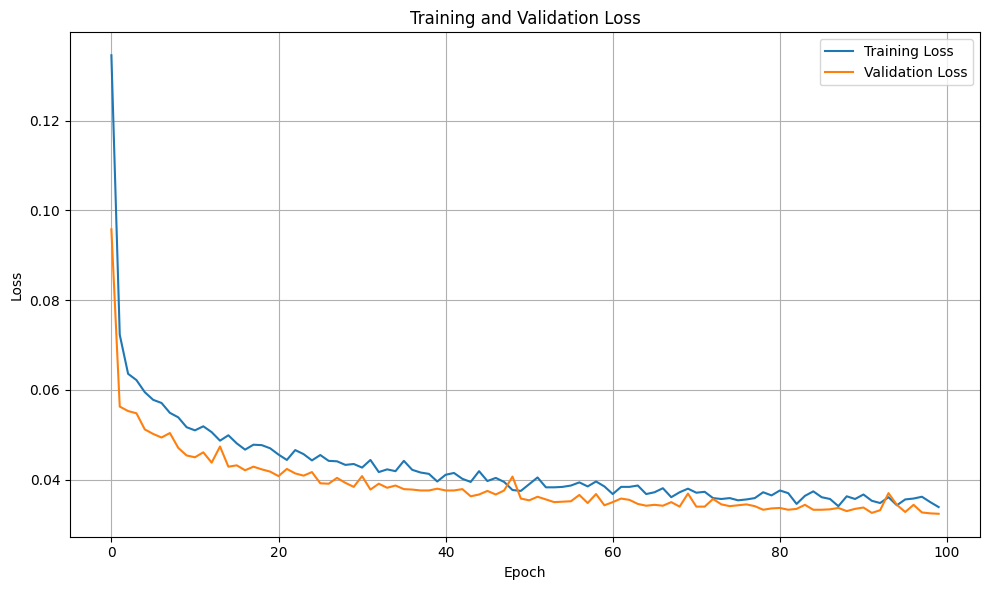

Final training loss: 0.0339
Final validation loss: 0.0324


In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

with open('./training_log.txt', 'r') as file:
    training_log = file.read()


# Extract metrics from training log
metrics = []
for line in training_log.split('\n'):
    if 'loss:' in line and 'val_loss:' in line:
        parts = line.split('-')
        values = {}
        for part in parts:
            if 'loss:' in part or 'mae:' in part or 'val_loss:' in part or 'val_mae:' in part:
                key, value = part.strip().split(':')
                values[key] = float(value)
        metrics.append(values)

# Convert to DataFrame
df = pd.DataFrame(metrics)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df['loss'], label='Training Loss')
plt.plot(df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print final metrics
print(f"Final training loss: {df['loss'].iloc[-1]:.4f}")
print(f"Final validation loss: {df['val_loss'].iloc[-1]:.4f}")

### Inference

- Load model
- Load cached test images
- Make predictions and display noisy, predicted and target images
- Evaluate the model performance on a test set of images
- Pipeline for single image prediction


In [46]:

# Load the best model saved during training

model_path = '/content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5'

model = get_network(image_size=512,
                   widths=[32, 48, 64, 128, 160],
                   is_gray=True)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
             loss=document_focused_loss,
             metrics=['mae'])

model.load_weights(model_path)

# Verify weights loaded
print(f"Model has {model.count_params()} parameters")


Model has 3159377 parameters


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 202 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [47]:
# Load large images for evaluating loss
# ----------------- LARGE TEST IMAGES -----------------------------------------------------

data_dir = '/content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/shabby01'
large_cache_dir = Path(f'{data_dir}/shabby/shabby_images_cache'); large_cache_dir.mkdir(exist_ok=True)


test_shabby_img = [os.path.join(f'{data_dir}/shabby/test/test_shabby/', img) for img in sorted(os.listdir(f'{data_dir}/shabby/test/test_shabby/'))]
test_cleaned_img = [os.path.join(f'{data_dir}/shabby/test/test_cleaned/', img) for img in sorted(os.listdir(f'{data_dir}/shabby/test/test_cleaned/'))]
# print(len(test_shabby_img), len(test_cleaned_img))

# only loading 10 for testing, comment out if not needed
test_shabby_img = test_shabby_img[:10]
test_cleaned_img = test_cleaned_img[:10]
print(len(test_shabby_img), len(test_cleaned_img))

X_test = load_or_process_images(test_shabby_img, large_cache_dir / "X_test_10.pkl")
Y_test = load_or_process_images(test_cleaned_img, large_cache_dir / "Y_test_10.pkl")




10 10
Loading cached data from /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/shabby01/shabby/shabby_images_cache/X_test_10.pkl
Loading cached data from /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/shabby01/shabby/shabby_images_cache/Y_test_10.pkl


Processing image pair 2
shabby image: /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/shabby01/shabby/test/test_shabby/0003-FederalReserve-monetarypolicy_fomc_longerrungoals.pdf-1.png

cleaned image: /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/shabby01/shabby/test/test_cleaned/0003-FederalReserve-monetarypolicy_fomc_longerrungoals.pdf-1.png

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step
Processing image pair 9
shabby image: /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_mod

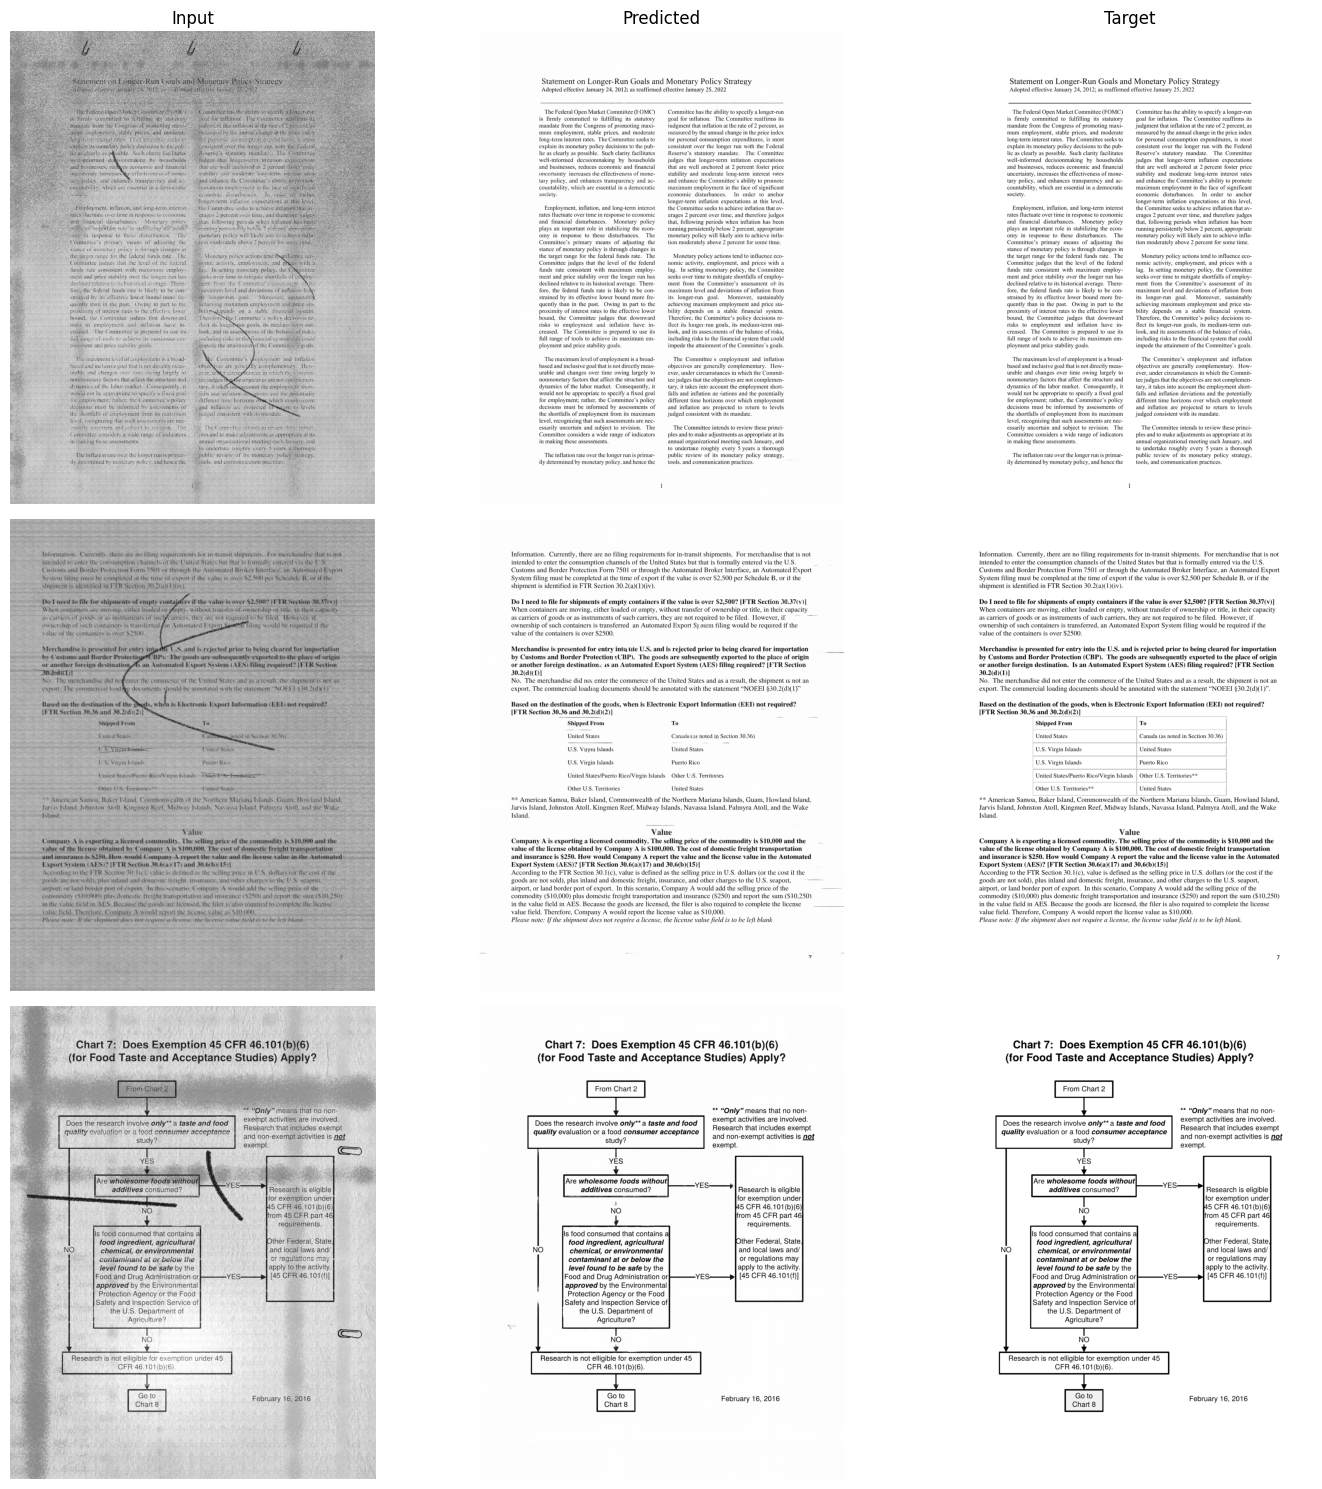

In [48]:
# Entire Inference Pipeline for predicting on random test images
# The model has not seen these test images
# The steps are shown in the next sub-section
# NOTE: this t
def process_multiple_predictions(test_shabby_img, test_cleaned_img, model, num_samples=3):
    """
    Process multiple image pairs for prediction, reconstruct predictions, and visualize results.
    Args:    test_shabby_img (list of str): input shabby images paths.
             test_cleaned_img (list of str): input cleaned|target images paths.
             model (tf.keras.Model): Trained model for prediction.
             num_samples (int): Number of image pairs to process and display. Default is 3.
    Returns: None
    """

    indices = np.random.choice(len(test_shabby_img), num_samples, replace=False)

    plt.figure(figsize=(15, 5*num_samples))

    for idx, n in enumerate(indices):
        print(f"Processing image pair {n}")

        # Read shabby and clean images
        input_image = cv2.imread(test_shabby_img[n], 0)
        target_image = cv2.imread(test_cleaned_img[n], 0)
        print(f"shabby image: {test_shabby_img[n]}\n")
        print(f"cleaned image: {test_cleaned_img[n] }\n")

        # Split input image into patches
        windows, positions = split_image(input_image, 512, 512)
        patches_array = np.array(windows)
        rows = int(np.ceil(input_image.shape[0] / 512))
        cols = int(np.ceil(input_image.shape[1] / 512))
        patches_array = patches_array.reshape(rows, cols, 512, 512)

        # Get predicted patches
        predicted_patches = []
        for i in range(rows):
            for j in range(cols):
                single_patch = patches_array[i,j] / 255.  # Normalize patch

                # match patch to the expected input shape for most TensorFlow models (e.g., (batch_size, height, width, channels)).
                # (512, 512) --> (512, 512, 1) ---> (1, 512, 512, 1) : (1, height, width, channels)
                single_patch = np.expand_dims(np.expand_dims(single_patch, axis=2), 0) # Add batch and channel dimensions
                prediction = model.predict(single_patch) # Predict patch
                predicted_patches.append(prediction[0,:,:,0]) # Extract prediction

        # Reshape and reconstruct predicted patches
        predicted_patches = np.array(predicted_patches).reshape(rows, cols, 512, 512)
        reconstructed_image = stitch_image(predicted_patches.reshape(-1, 512, 512),
                                         input_image.shape, 512, 512)

        # Plot in grid for input, predicted and target images
        # Shabby input
        plt.subplot(num_samples, 3, idx*3 + 1)
        plt.imshow(input_image/255., cmap='gray', vmin=0, vmax=1)
        plt.title('Input' if idx == 0 else '')
        plt.axis('off')

        # Predicted
        plt.subplot(num_samples, 3, idx*3 + 2)
        plt.imshow(reconstructed_image, cmap='gray', vmin=0, vmax=1)
        plt.title('Predicted' if idx == 0 else '')
        plt.axis('off')

        # Target
        plt.subplot(num_samples, 3, idx*3 + 3)
        plt.imshow(target_image/255., cmap='gray', vmin=0, vmax=1)
        plt.title('Target' if idx == 0 else '')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Usage
process_multiple_predictions(test_shabby_img, test_cleaned_img, model, num_samples=3)

In [53]:
# Loss evaluation on test sets

def evaluate_test_set(test_shabby_img, test_cleaned_img, model):
    """Evaluate the test set using the provided model. Images are patched in this function so inputs are large images
        Inputs:  test_shabby_img , test_cleaned_img: lists of str
                 model : keras.Model
        Returns: dict --> 'avg_loss' : float,
                          'individual_losses' : list of tuples
    """
    losses = []

    for idx in range(3):
        print(f"Processing test image {idx+1}/{len(test_shabby_img)}")

        input_image = cv2.imread(test_shabby_img[idx], 0)
        target_image = cv2.imread(test_cleaned_img[idx], 0)

        if target_image.shape != input_image.shape:
            target_image = cv2.resize(target_image, (input_image.shape[1], input_image.shape[0]))

        target_image = target_image.astype('float32') / 255.0

        # Rest of the processing remains same until loss calculation
        windows, positions = split_image(input_image, 512, 512)
        patches_array = np.array(windows)
        rows = int(np.ceil(input_image.shape[0] / 512))
        cols = int(np.ceil(input_image.shape[1] / 512))
        patches_array = patches_array.reshape(rows, cols, 512, 512)

        predicted_patches = []
        for i in range(rows):
            for j in range(cols):
                single_patch = patches_array[i,j].astype('float32') / 255.
                single_patch = np.expand_dims(np.expand_dims(single_patch, axis=2), 0)
                prediction = model.predict(single_patch, verbose=0)
                predicted_patches.append(prediction[0,:,:,0])

        predicted_patches = np.array(predicted_patches, dtype='float32').reshape(rows, cols, 512, 512)
        reconstructed_image = stitch_image(predicted_patches.reshape(-1, 512, 512),
                                         input_image.shape, 512, 512)

        y_true = tf.convert_to_tensor(target_image[np.newaxis, ..., np.newaxis], dtype=tf.float32)
        y_pred = tf.convert_to_tensor(reconstructed_image[np.newaxis, ..., np.newaxis], dtype=tf.float32)

        # Calculate and reduce loss to scalar
        loss = tf.reduce_mean(document_focused_loss(y_true, y_pred))
        losses.append(float(loss.numpy()))

        print(f"Current average loss: {np.mean(losses):.4f}")

    return {
        'avg_loss': np.mean(losses),
        'individual_losses': list(zip(test_shabby_img[:3], losses))
    }

# Usage
results = evaluate_test_set(test_shabby_img, test_cleaned_img, model)

print(f"\nAverage Document Focused Loss: {results['avg_loss']:.4f}") # 0.253

# print("\nIndividual Losses:")
# for idx, (file_name, loss) in enumerate(results['individual_losses'], start=1):
#     print(f"{idx}. File: {file_name.rsplit('/',1)[-1]}, Loss: {loss:.4f}")



Average Document Focused Loss: 0.0438

Average Document Focused Loss: [('/content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/shabby01/shabby/test/test_shabby/0002-HHS-ocse_eiwo_paperless_solution_presentation.pdf-09.png', 0.06699547916650772), ('/content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/shabby01/shabby/test/test_shabby/0002-HHS-ocse_eiwo_paperless_solution_presentation.pdf-17.png', 0.043539684265851974), ('/content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/shabby01/shabby/test/test_shabby/0003-FederalReserve-monetarypolicy_fomc_longerrungoals.pdf-1.png', 0.020854996517300606)]

Individual Losses:
1. File: 0002-HHS-ocse_eiwo_paperless_solution_presentation.pdf-09.png, Loss: 0.0670
2. File: 0002-HHS-ocse_eiwo_paperless_solution_presentation.pdf-17.png, Loss: 0.0435
3. File: 0003-FederalReserve-monetarypolicy_fomc_longerrungoals.pdf-1.png, Loss: 0.0209


#### Individual kernels for patching, predicting, unpatching

In [ ]:
# Process Large image into patches before prediction

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read image
large_image = cv2.imread(test_shabby_img[0], 0)

# Split image into patches
windows, positions = split_image(large_image, window_height=512, window_width=512)

# Convert windows list to numpy array for easier handling
patches_array = np.array(windows)
rows = int(np.ceil(large_image.shape[0] / 512))
cols = int(np.ceil(large_image.shape[1] / 512))
patches_array = patches_array.reshape(rows, cols, 512, 512)

print("Large image shape is: ", large_image.shape)
print("Patches array shape is: ", patches_array.shape)

# Display original image
bx = plt.figure(figsize=(9, 9))
bx = plt.imshow(large_image, cmap='gray')
bx = plt.show()

# Display patches
plt.figure(figsize=(9, 9))
ix = 1
for i in range(rows):
    for j in range(cols):
        ax = plt.subplot(rows, cols, ix)
        bx = ax.set_xticks([])
        bx = ax.set_yticks([])
        bx = plt.imshow(patches_array[i, j], cmap='gray')
        ix += 1
plt.show()



Predicting patch 0,0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
Predicting patch 0,1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
Predicting patch 0,2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
Predicting patch 1,0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
Predicting patch 1,1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
Predicting patch 1,2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
Predicting patch 2,0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
Predicting patch 2,1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting patch 2,2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Predicting patch 3,0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicting patch 3,1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
Predicting patch 3,2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


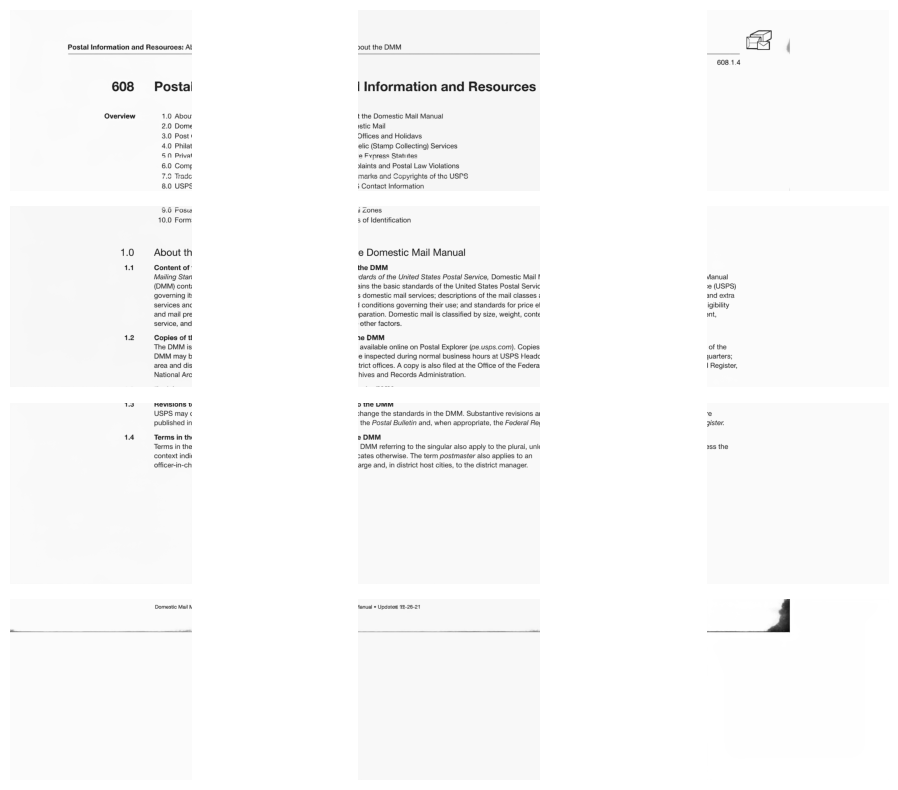

In [ ]:
# Now patch and use for prediction


import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_patches(windows, rows, cols, model):
    """
    Processes patches for an image, predicts results for each patch,
    and visualizes them individually.

    Args: windows (numpy.ndarray): Input image patches.
          rows (int): Number of rows of patches.
          cols (int): Number of columns of patches.
          model (tf.keras.Model): Trained model for prediction.
    Returns: numpy.ndarray: Predicted patches reshaped into (rows, cols, height, width).
    """
    predicted_patches = []

    for i in range(rows):
        for j in range(cols):
            print(f"Predicting patch {i},{j}")

            single_patch = patches_array[i,j]
            single_patch = single_patch / 255.
            single_patch = np.expand_dims(single_patch, axis=2) # Add channel dimension
            single_patch_input = np.expand_dims(single_patch, 0) # Add batch dimension

            prediction = model.predict(single_patch_input)
            predicted_patch = prediction[0,:,:,0]             # Extract the predicted patch
            predicted_patches.append(predicted_patch)

    # Reshape predicted patches into a grid matching the input layout
    predicted_patches = np.array(predicted_patches)
    predicted_patches_reshaped = predicted_patches.reshape(rows, cols, 512, 512)

    # Display results
    plt.figure(figsize=(12, 8))
    for i in range(rows):
        for j in range(cols):
            ax = plt.subplot(rows, cols, i*cols + j + 1)
            ax = plt.imshow(predicted_patches_reshaped[i, j], cmap='gray')
            ax = plt.axis('off') # Hide axes
    ax = plt.tight_layout() # Adjust layout for better visibility
    ax = plt.show()

    return predicted_patches_reshaped


# Usage for processing single large image
large_image = cv2.imread(test_shabby_img[0], 0)
windows, positions = split_image(large_image, window_height=512, window_width=512)
patches_array = np.array(windows)
rows = int(np.ceil(large_image.shape[0] / 512)) # get num of patch rows from large image
cols = int(np.ceil(large_image.shape[1] / 512)) # get num of patch cols ....
patches_array = patches_array.reshape(rows, cols, 512, 512) # reshape to 4D of patches (rows, cols, h, w)

# Run predictions
predicted_patches_reshaped = process_patches(patches_array, rows, cols, model)

<Figure size 1000x1000 with 0 Axes>

(-0.5, 1256.5, 1631.5, -0.5)

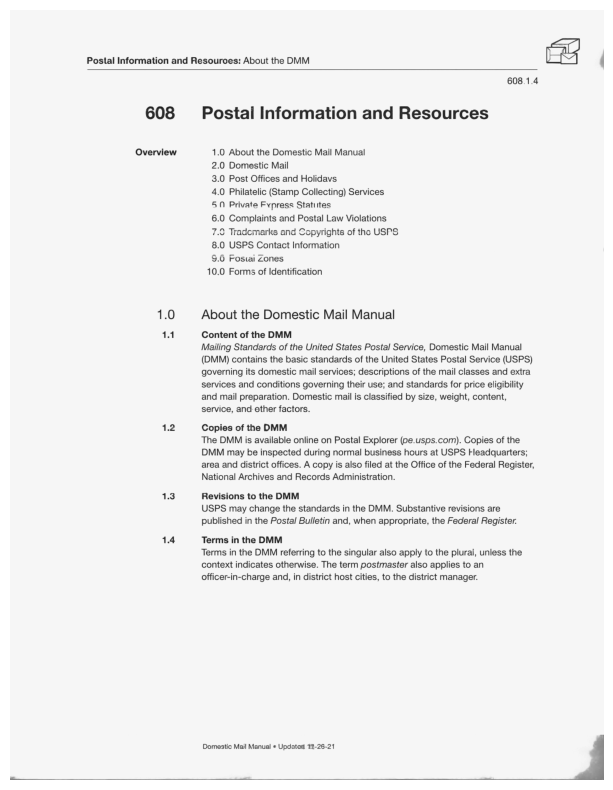

In [ ]:
# Stitch all patches together to reconstruct the images
# The model returns patches as well as predictions.

reconstructed_image = stitch_patches(predicted_patches_reshaped, large_image.shape, 512)

plt.figure(figsize=(10,10))
plt.imshow(reconstructed_image, cmap='gray')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


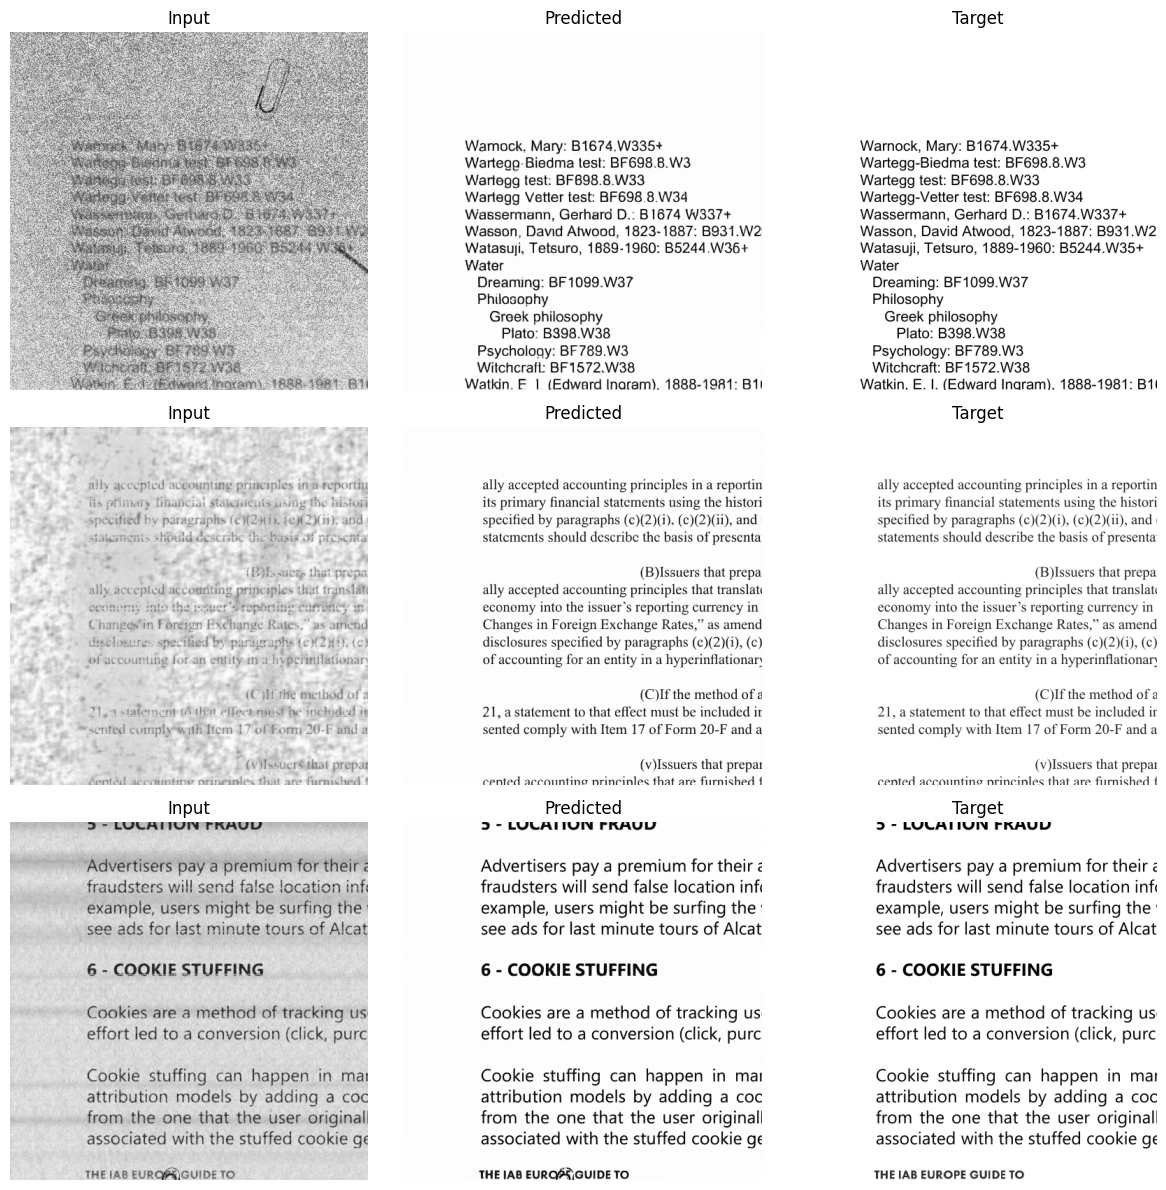

In [ ]:
# Display predictions side by side with shabby image and target clean image


def display_n_images(image_sets, titles=None, n_cols=3):
    """Display n images with their titles side by side"""
    n_sets = len(image_sets)
    if titles is None:
        titles = [['Input', 'Predicted', 'Target'] for _ in range(n_sets)]

    plt.figure(figsize=(12, 4*n_sets))
    for row in range(n_sets):
        for col in range(n_cols):
            plt.subplot(n_sets, n_cols, row*n_cols + col + 1)
            plt.imshow(image_sets[row][col].squeeze(), cmap='gray', vmin=0, vmax=1)
            plt.title(titles[row][col])
            plt.axis('off')
    plt.tight_layout()
    plt.show()


def display_predictions(X_val_p, Y_val_p, model, n_samples=3, indices=None):
   """Displays predictions from the model alongside inputs and targets.
      Args:
        X_val_p (numpy.ndarray), Y_val_p (numpy.ndarray): Validation shabby and clean patches.
        model (tf.keras.Model): Trained model for making predictions.
        n_samples (int): Number of samples to display. Default is 3.
        indices (list, optional): Specific indices of samples to display. Default is None.
      Returns:
          None
   """

   if indices is None: # Randomly select sample indices if none are provided
       indices = np.random.choice(len(X_val_p), n_samples, replace=False)

   # predict on test images
   test_imgs = X_val_p[indices]
   preds = model.predict(test_imgs)

   # Prepare a list of image sets: input, predicted, and target images
   image_sets = [ [test_imgs[i], preds[i], Y_val_p[indices[i]]] for i in range(n_samples) ]

   # Titles corresponding to each image set
   titles = [  ['Input', 'Predicted', 'Target'] for _ in range(n_samples) ]

   display_n_images(image_sets, titles)



# Example usage:
display_predictions(X_val_p, Y_val_p, model, n_samples=3, indices=[0,60, 90])
# Or with specific indices:
# display_predictions(X_val_p, Y_val_p, model, indices=[0,5,10])

### Progressive Hyper-parameter tuning with Optuna

In [ ]:
# To find best hyperparameters for training


def edge_preservation_loss(y_true, y_pred):
    """Calculate edge preservation loss using Sobel edges."""
    edge_true = tf.image.sobel_edges(y_true)
    edge_pred = tf.image.sobel_edges(y_pred)
    return tf.reduce_mean(tf.abs(edge_true - edge_pred))

def document_focused_loss(y_true, y_pred):
    """Combined loss focusing on structure, edges, and pixel accuracy."""
    ssim_score = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    edge_score = edge_preservation_loss(y_true, y_pred)
    mse_score = tf.keras.losses.mse(y_true, y_pred)

    return 0.6 * ssim_score + 0.3 * edge_score + 0.1 * mse_score



def get_metrics():
   return [
       'mae',
       tf.keras.metrics.MeanSquaredError(name='mse'),
       tf.keras.metrics.Mean(name='edge_preservation')(edge_preservation_loss)
   ]

# Alternative simpler loss function
def combined_ssim_mse_loss(y_true, y_pred):
    """Combine SSIM and MSE losses with weighted average."""
    ssim = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    mse = tf.keras.losses.mse(y_true, y_pred)
    return 0.7 * ssim + 0.3 * mse

# Your existing model code
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def combined_loss(y_true, y_pred):
    ssim = ssim_loss(y_true, y_pred)
    mse = tf.keras.losses.mse(y_true, y_pred)
    return 0.7 * ssim + 0.3 * mse


In [ ]:
# Hyperparameter Configuration
# Parameter	Possible Values	Description
# input_size	          ---> [128, 256, 512]	The size of the input images.
# initial_filters	      ---> [32, 64]	The number of filters in the initial convolutional layer.
# depth	                ---> Integers from 3 to 10 (inclusive)	The depth of the network, representing the number of layers or blocks.
# block_depth	          ---> Integers from 2 to 4 (inclusive)	The depth of each block within the network.
# widths_multiplier	    ---> Floats between 1.5 and 2.0	A multiplier to adjust the widths (number of filters) across layers or blocks.
# dropout_rate          --->	Floats between 0.0 and 0.5	The dropout rate used to prevent overfitting.
# batch_size	          ---> [2, 4, 8]	The number of samples processed before the model is updated.
# learning_rate         --->	Continuous values between 1e-5 and 1e-3 (log scale)	The step size at each iteration while moving toward a minimum of a loss function.

In [ ]:
import json
import os
import tensorflow as tf
import gc
import numpy as np
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.mixed_precision import set_global_policy

try: # import if installed, else install first
  import optuna
except ImportError:
  !pip install -qU optuna
  import optuna
from optuna.trial import Trial


set_global_policy('mixed_float16')

import tensorflow as tf


def save_study_results(study, phase_number):
    """Saves the results of an Optuna study to a JSON file."""

    results = {
        'best_params': study.best_params,
        'best_value': study.best_value,
        'phase': phase_number
    }
    os.makedirs('unet_optimization_results', exist_ok=True)
    with open(f'unet_optimization_results/phase_{phase_number}_results.json', 'w') as f:
        json.dump(results, f)

def load_previous_results():
    """Loads and sorts previous optimization results from the results directory."""

    results = []
    results_dir = 'unet_optimization_results'
    if os.path.exists(results_dir):
        for file in os.listdir(results_dir):
            if file.endswith('_results.json'):
                with open(os.path.join(results_dir, file), 'r') as f:
                    results.append(json.load(f))
    return sorted(results, key=lambda x: x['phase'])

def create_search_space(trial: Trial):
    """Defines the default hyperparameter search space for Optuna trials."""

    params = {
        'input_size': 512, #trial.suggest_categorical('input_size', [128, 256, 512]),
        'initial_filters': 32, #trial.suggest_categorical('initial_filters', [32, 64]),
        'depth': 8, #trial.suggest_int('depth', 3, 10),
        'block_depth': 4, #trial.suggest_int('block_depth', 2, 4),
        'widths_multiplier': 2, #trial.suggest_float('widths_multiplier', 1.5, 2.0),
        'dropout_rate': 0.5, #trial.suggest_float('dropout_rate', 0.0, 0.5),
        'batch_size': 4, #trial.suggest_categorical('batch_size', [2, 4, 8]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True),
    }
    return params

def create_informed_search_space(trial: Trial, previous_results):
    """Creates a hyperparameter search space for the trial,
        leveraging previous results if available."""

    if previous_results: # Retrieve the best parameters from previous results
        best_previous = min(previous_results, key=lambda x: x['best_value'])
        best_params = best_previous['best_params']

        # Define informed search space based on best parameters, with curated upper and lower bounds
        params = {
            'input_size': 512, # trial.suggest_categorical('input_size', [best_params['input_size']]),
            'initial_filters': 32,  #trial.suggest_categorical('initial_filters', [max(32, int(best_params['initial_filters'] * 0.8)), best_params['initial_filters'], min(128, int(best_params['initial_filters'] * 1.2))]),
            'depth': 8, # trial.suggest_int('depth', max(3, best_params['depth'] - 1), (5, best_params['depth'] + 1)),
            'block_depth': 4, #trial.suggest_int('block_depth', max(2, best_params['block_depth'] - 1), min(4, best_params['block_depth'] + 1)),
            'widths_multiplier': 2, #trial.suggest_float('widths_multiplier', max(1.5, best_params['widths_multiplier'] * 0.9), min(2.5, best_params['widths_multiplier'] * 1.1)),
            'dropout_rate': 0.5, #trial.suggest_float('dropout_rate', max(0.0, best_params['dropout_rate'] - 0.1), min(0.5, best_params['dropout_rate'] + 0.1)),
            'batch_size': 4, #trial.suggest_categorical('batch_size', [best_params['batch_size']]),

            'learning_rate': trial.suggest_float('learning_rate',
                best_params['learning_rate'] * 0.5,
                best_params['learning_rate'] * 2,
                log=True),
        }
    else: # Fall back to the default search space if no previous results are available
        params = create_search_space(trial)
    return params

def objective(trial: Trial, params, EPOCHS, X_train_p, Y_train_p, X_val_p, Y_val_p):
    """Define the objective function for progressive hyperparameter tuning"""

    # gc and clear tf session
    gc.collect()
    try:
        tf.keras.backend.clear_session()
    except AssertionError:
        print("Skipping clear_session due to nested graph context.")

    # Reset GPU memory stats for fresh GPU usage tracking
    tf.config.experimental.reset_memory_stats('GPU:0')

    try:
        with tf.device('/GPU:0'): # Explicitly use the GPU for model training
            model = get_network(params) # Create a new model with the provided parameters


            history = model.fit(
                X_train_p, Y_train_p,
                batch_size=params['batch_size'],
                epochs=EPOCHS,
                validation_data=(X_val_p, Y_val_p),
                callbacks=[EarlyStoppingCallback(), PruningCallback(trial)],
                verbose=1
            )

            # Retrieve the minimum validation loss from training history
            score = min(history.history['val_loss'])

            # Clean up the model and session to release memory
            del model
            tf.keras.backend.clear_session()
            gc.collect()

            return score

    except Exception as e:
        tf.keras.backend.clear_session()
        gc.collect()
        raise optuna.TrialPruned(f"Trial failed: {str(e)}")

def run_optimization_phase(phase_number, epoch_params, X_train_p, Y_train_p, X_val_p, Y_val_p):
    """Run an optuna optimization phase using to tune hyperparameters for a specific phase."""

    NUM_TRIALS = epoch_params['NUM_TRIALS']
    NUM_STARTUP_TRIALS = epoch_params['NUM_STARTUP_TRIALS']
    EPOCHS = epoch_params['EPOCHS']

    # Load results from previous optimization phases, if available
    previous_results = load_previous_results()

    # Create study with a MedianPruner for pruning suboptimal trials
    study = optuna.create_study(
        direction='minimize',
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=NUM_STARTUP_TRIALS,
            n_warmup_steps=3,
            interval_steps=2
        )
    )

    # Define the objective function for the phase
    def phase_objective(trial):
        params = create_informed_search_space(trial, previous_results)
        return objective(trial, params, EPOCHS, X_train_p, Y_train_p, X_val_p, Y_val_p)

    study.optimize(
        phase_objective,
        n_trials=NUM_TRIALS,
        gc_after_trial=True
    )

    save_study_results(study, phase_number)
    return study

# Example usage:
epoch_params = {
    'NUM_TRIALS': 2,
    'NUM_STARTUP_TRIALS': 2,
    'EPOCHS': 2
}

# Run multiple phases
def run_tuning(X_train_p, Y_train_p, X_val_p, Y_val_p, start_phase=0, num_phases=3):
    """Run multiple optimization sessions over specified number of phases"""

    for phase in range(start_phase, start_phase + num_phases):
        print(f"Starting optimization phase {phase + 1}")
        gc.collect()

        try:
            tf.keras.backend.clear_session()
        except AssertionError:
            print("Skipping clear_session due to nested graph context.")

        study = run_optimization_phase(phase + 1, epoch_params, X_train_p, Y_train_p, X_val_p, Y_val_p)

        print(f"Phase {phase + 1} complete")
        print(f"Best value: {study.best_trial.value}")
        print(f"Best parameters: {study.best_trial.params}")

# run_tuning(X_train_p, Y_train_p, X_val_p, Y_val_p, start_phase=0, num_phases=1)

In [49]:
run_tuning(X_train_p, Y_train_p, X_val_p, Y_val_p, start_phase=0, num_phases=1)